Dataset shape: (208, 61)
Class counts:
 60
M    111
R     97
Name: count, dtype: int64
Missing values: 0


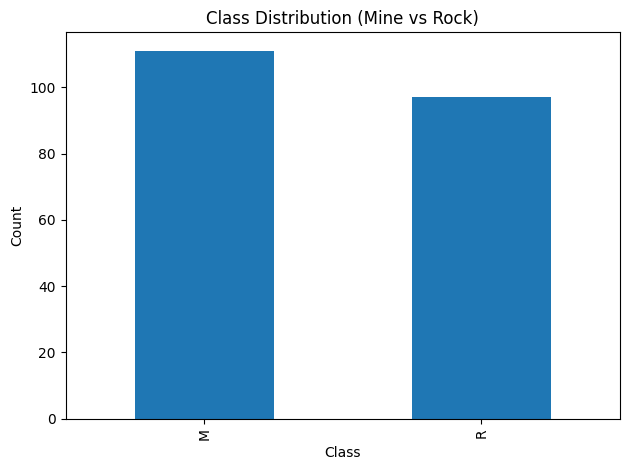

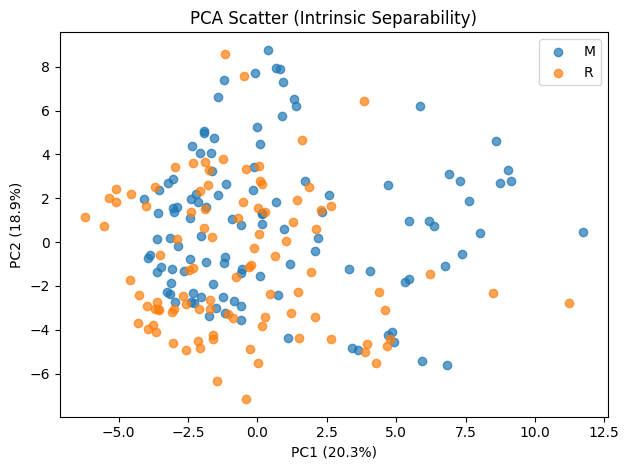

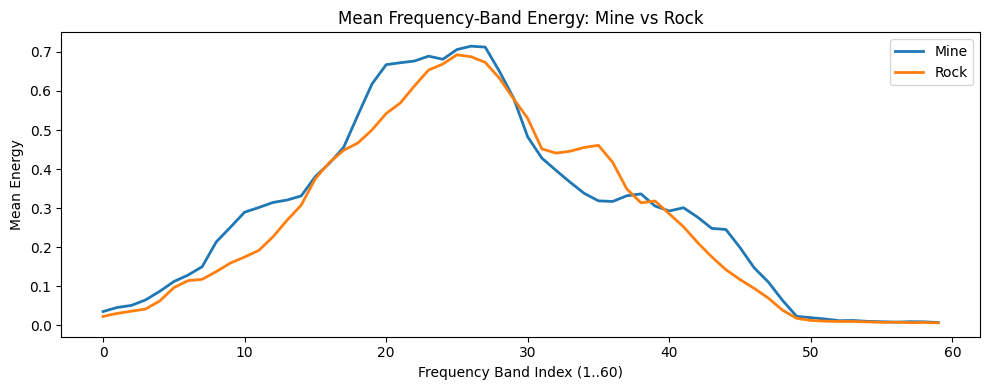


Repeated CV Accuracy:
Logistic Regression: 0.758 ± 0.063
SVM (RBF): 0.830 ± 0.058
Random Forest: 0.822 ± 0.067


C:\Users\VICTUS\AppData\Local\Temp\ipykernel_22332\1253039326.py:142: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([cv_scores[k] for k in cv_scores], labels=list(cv_scores.keys()))


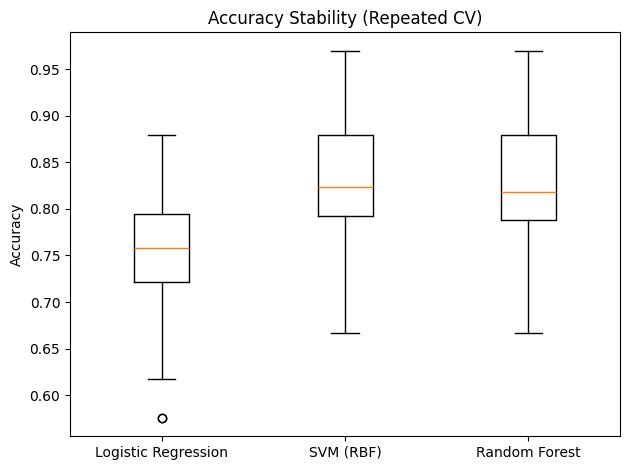


FINAL TEST RESULTS (SVM)
Accuracy: 0.857
F1-macro: 0.854
Precision-macro: 0.873
Recall-macro: 0.852
ROC-AUC: 0.925

              precision    recall  f1-score   support

           M      0.808     0.955     0.875        22
           R      0.938     0.750     0.833        20

    accuracy                          0.857        42
   macro avg      0.873     0.852     0.854        42
weighted avg      0.870     0.857     0.855        42


Sample Predictions:
    True_Label Predicted_Label   P(Mine)
0           R               R  0.085469
1           R               M  0.555641
2           R               M  0.714334
3           M               M  0.894596
4           M               M  0.875047
5           M               M  0.990288
6           M               M  0.969514
7           R               R  0.086245
8           M               M  0.698064
9           M               R  0.211664
10          R               R  0.028616
11          M               M  0.846995


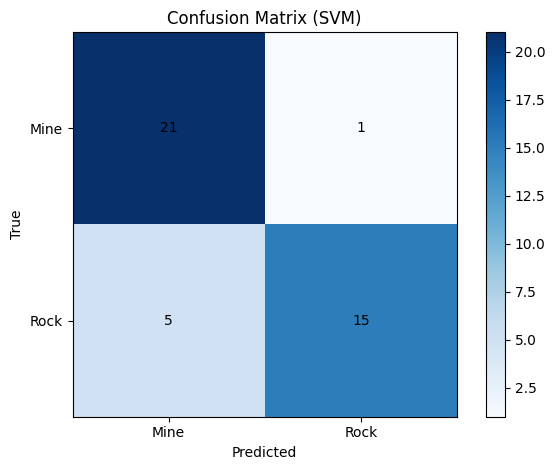

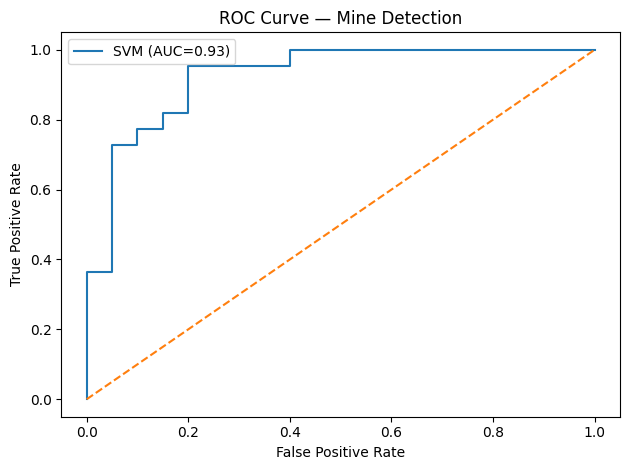

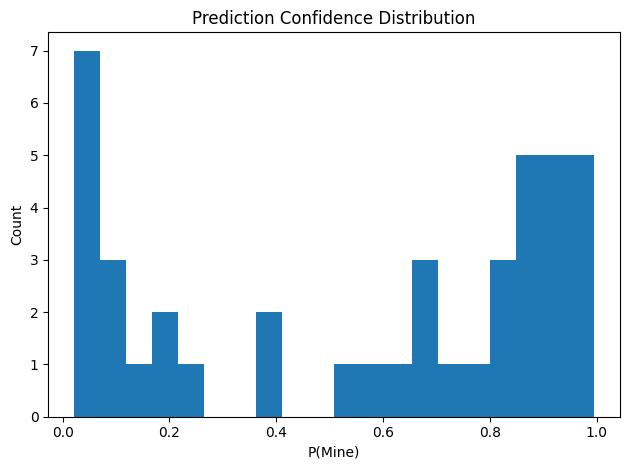

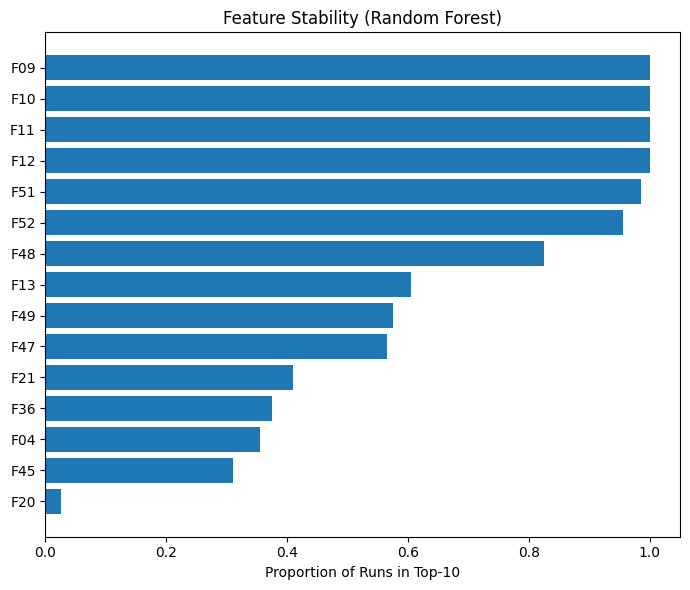

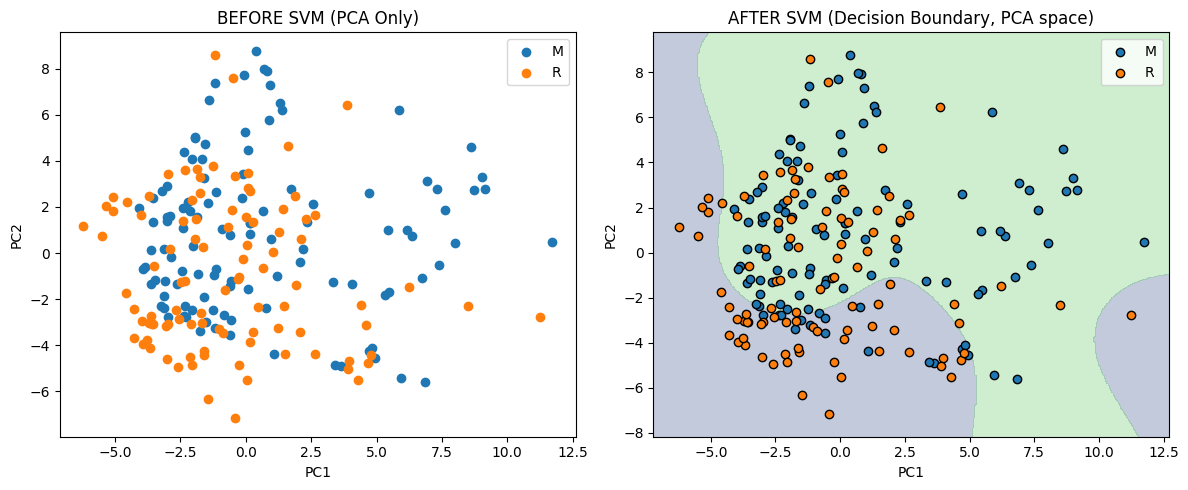


✅ PROJECT COMPLETE — All outputs saved to: sonar_outputs


In [1]:
# =========================================================
# SONAR MINE vs ROCK DETECTION — FINAL MASTER'S PROJECT
# 
# =========================================================

import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve, classification_report
)

# -------------------------
# CONFIG
# -------------------------
ZIP_PATH = "connectionist+bench+sonar+mines+vs+rocks.zip"  # adjust path if needed
DATA_FILE = "sonar.all-data"
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

OUT_DIR = "sonar_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

def save_fig(name):
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, name), dpi=300, bbox_inches="tight")

# =========================================================
# 1) DATA ACQUISITION
# =========================================================
with zipfile.ZipFile(ZIP_PATH, "r") as z:
    raw = z.read(DATA_FILE).decode("utf-8").strip().splitlines()

df = pd.DataFrame([r.split(",") for r in raw])
X = df.iloc[:, :60].astype(float)
y = df.iloc[:, 60].astype(str)
X.columns = [f"F{i:02d}" for i in range(1, 61)]

print("Dataset shape:", df.shape)
print("Class counts:\n", y.value_counts())
print("Missing values:", X.isna().sum().sum())

# =========================================================
# 2) EDA — Class Distribution
# =========================================================
plt.figure()
y.value_counts().plot(kind="bar")
plt.title("Class Distribution (Mine vs Rock)")
plt.xlabel("Class"); plt.ylabel("Count")
save_fig("slide5_class_distribution.png")
plt.show()

# =========================================================
# 3) EDA — PCA (PC1 vs PC2) for intrinsic separability
# =========================================================
X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)
pc1_var, pc2_var = pca.explained_variance_ratio_

plt.figure()
for cls in ["M", "R"]:
    idx = (y == cls).values
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], alpha=0.7, label=cls)
plt.xlabel(f"PC1 ({pc1_var*100:.1f}%)")
plt.ylabel(f"PC2 ({pc2_var*100:.1f}%)")
plt.title("PCA Scatter (Intrinsic Separability)")
plt.legend()
save_fig("slide6_pca_pc1_pc2.png")
plt.show()

# =========================================================
# 4) Signal Characteristics — Mean Frequency-Band Energy
# =========================================================
mean_m = X[y == "M"].mean()
mean_r = X[y == "R"].mean()

plt.figure(figsize=(10,4))
plt.plot(mean_m.values, linewidth=2, label="Mine")
plt.plot(mean_r.values, linewidth=2, label="Rock")
plt.xlabel("Frequency Band Index (1..60)")
plt.ylabel("Mean Energy")
plt.title("Mean Frequency-Band Energy: Mine vs Rock")
plt.legend()
save_fig("slide7_mean_frequency_energy.png")
plt.show()

# =========================================================
# 5) PREPROCESSING — Train/Test Split (Stratified)
# =========================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

# =========================================================
# 6) MODEL DEFINITIONS
# =========================================================
logreg = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000))
])

svm = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC(kernel="rbf", probability=True))
])

rf = RandomForestClassifier(n_estimators=600, random_state=RANDOM_STATE)

models = {
    "Logistic Regression": logreg,
    "SVM (RBF)": svm,
    "Random Forest": rf
}

# =========================================================
# 7) VALIDATION — Repeated Stratified CV (Robustness)
# =========================================================
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=20, random_state=RANDOM_STATE)
cv_scores = {}

print("\nRepeated CV Accuracy:")
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring="accuracy")
    cv_scores[name] = scores
    print(f"{name}: {scores.mean():.3f} ± {scores.std():.3f}")

plt.figure()
plt.boxplot([cv_scores[k] for k in cv_scores], labels=list(cv_scores.keys()))
plt.ylabel("Accuracy")
plt.title("Accuracy Stability (Repeated CV)")
save_fig("slide8_cv_accuracy_boxplot.png")
plt.show()

# =========================================================
# 8) FINAL MODEL — Train SVM on full 60D data
# =========================================================
final_model = svm
final_model.fit(X_train, y_train)

# =========================================================
# 9) PREDICTION & EVALUATION (Unseen Test Set)
# =========================================================
y_pred = final_model.predict(X_test)
y_prob = final_model.predict_proba(X_test)
mine_idx = list(final_model.classes_).index("M")

acc = accuracy_score(y_test, y_pred)
f1m = f1_score(y_test, y_pred, average="macro")
precm = precision_score(y_test, y_pred, average="macro")
recm = recall_score(y_test, y_pred, average="macro")
auc = roc_auc_score((y_test == "M").astype(int), y_prob[:, mine_idx])

print("\nFINAL TEST RESULTS (SVM)")
print(f"Accuracy: {acc:.3f}")
print(f"F1-macro: {f1m:.3f}")
print(f"Precision-macro: {precm:.3f}")
print(f"Recall-macro: {recm:.3f}")
print(f"ROC-AUC: {auc:.3f}\n")
print(classification_report(y_test, y_pred, digits=3))

# Sample prediction table (for PPT)
sample_pred = pd.DataFrame({
    "True_Label": y_test.values,
    "Predicted_Label": y_pred,
    "P(Mine)": y_prob[:, mine_idx]
}).head(12)
sample_pred.to_csv(os.path.join(OUT_DIR, "slide8_sample_predictions.csv"), index=False)
print("\nSample Predictions:\n", sample_pred)

# =========================================================
# 10) DETECTION ANALYSIS — Confusion Matrix & ROC
# =========================================================
cm = confusion_matrix(y_test, y_pred, labels=["M", "R"])

plt.figure()
plt.imshow(cm, cmap="Blues")
plt.colorbar()
plt.xticks([0,1], ["Mine","Rock"])
plt.yticks([0,1], ["Mine","Rock"])
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title("Confusion Matrix (SVM)")
for (i,j), v in np.ndenumerate(cm):
    plt.text(j, i, int(v), ha="center", va="center")
save_fig("slide9_confusion_matrix.png")
plt.show()

fpr, tpr, _ = roc_curve((y_test == "M").astype(int), y_prob[:, mine_idx])
plt.figure()
plt.plot(fpr, tpr, label=f"SVM (AUC={auc:.2f})")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Mine Detection")
plt.legend()
save_fig("slide9_roc_curve.png")
plt.show()

# Prediction confidence
plt.figure()
plt.hist(y_prob[:, mine_idx], bins=20)
plt.xlabel("P(Mine)"); plt.ylabel("Count")
plt.title("Prediction Confidence Distribution")
save_fig("confidence_histogram.png")
plt.show()

# =========================================================
# 11) FEATURE STABILITY — Evidence for Feature Dominance
# =========================================================
RUNS = 200
counts = np.zeros(X.shape[1])

for seed in range(RUNS):
    rf_tmp = RandomForestClassifier(n_estimators=300, random_state=seed)
    rf_tmp.fit(X_train, y_train)
    top_idx = np.argsort(rf_tmp.feature_importances_)[-10:]
    counts[top_idx] += 1

stability = pd.DataFrame({
    "Feature": X.columns,
    "Top10_Frequency": counts / RUNS
}).sort_values("Top10_Frequency", ascending=False)

stability.to_csv(os.path.join(OUT_DIR, "feature_stability_full.csv"), index=False)

top15 = stability.head(15).iloc[::-1]
plt.figure(figsize=(7,6))
plt.barh(top15["Feature"], top15["Top10_Frequency"])
plt.xlabel("Proportion of Runs in Top-10")
plt.title("Feature Stability (Random Forest)")
save_fig("slide10_feature_stability.png")
plt.show()

# =========================================================
# 12) OPTIONAL — BEFORE vs AFTER (Visualization Only)
# =========================================================
svm_2d = SVC(kernel="rbf")
svm_2d.fit(X_pca, y)

x_min, x_max = X_pca[:,0].min()-1, X_pca[:,0].max()+1
y_min, y_max = X_pca[:,1].min()-1, X_pca[:,1].max()+1
xx, yy = np.meshgrid(np.linspace(x_min,x_max,400), np.linspace(y_min,y_max,400))
Z = svm_2d.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
for cls in ["M","R"]:
    idx = (y==cls).values
    plt.scatter(X_pca[idx,0], X_pca[idx,1], label=cls)
plt.title("BEFORE SVM (PCA Only)")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.legend()

plt.subplot(1,2,2)
plt.contourf(xx, yy, Z=="M", alpha=0.3)
for cls in ["M","R"]:
    idx = (y==cls).values
    plt.scatter(X_pca[idx,0], X_pca[idx,1], label=cls, edgecolor="k")
plt.title("AFTER SVM (Decision Boundary, PCA space)")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.legend()

save_fig("before_after_svm_pca.png")
plt.show()

print("\n✅ PROJECT COMPLETE — All outputs saved to:", OUT_DIR)
